# Wind Turbine Data - Exploratory Data Analysis

## Overview
Advanced exploratory analysis focusing on high-impact visualizations and post-failure recovery behavior.

### Key Features
1.  **Clean Code**: Optimized for readability.
2.  **Enhanced Visualization**: Large plots, Pie Charts, and KDE distributions.
3.  **Physics-Based**: Power Curve Analysis.
4.  **Temporal Context**: Seasonal Analysis & Post-Failure Recovery.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

## 1. Data Loading & Preprocessing

In [2]:
scada = pd.read_csv("Datasets/SCADA/EDP-SCADA-2017.csv")
failure = pd.read_csv("Datasets/SCADA/EDP-Failure-2017.csv")

scada['Timestamp'] = pd.to_datetime(scada['Timestamp'])
failure['Timestamp'] = pd.to_datetime(failure['Timestamp'])

scada = scada.sort_values(['Turbine_ID', 'Timestamp']).reset_index(drop=True)
failure = failure.sort_values(['Turbine_ID', 'Timestamp']).reset_index(drop=True)

scada_cols = [col for col in scada.columns if col not in ['Timestamp', 'Turbine_ID']]
scada[scada_cols] = scada.groupby('Turbine_ID')[scada_cols].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

WINDOW_HOURS = 48
scada['Label'] = 0

for _, fail_row in failure.iterrows():
    turbine = fail_row['Turbine_ID']
    fail_time = fail_row['Timestamp']
    
    mask = (
        (scada['Turbine_ID'] == turbine) &
        (scada['Timestamp'] <= fail_time) &
        (scada['Timestamp'] >= fail_time - pd.Timedelta(hours=WINDOW_HOURS))
    )
    scada.loc[mask, 'Label'] = 1

df = scada

## 2. Failure Distribution (Pie Chart)

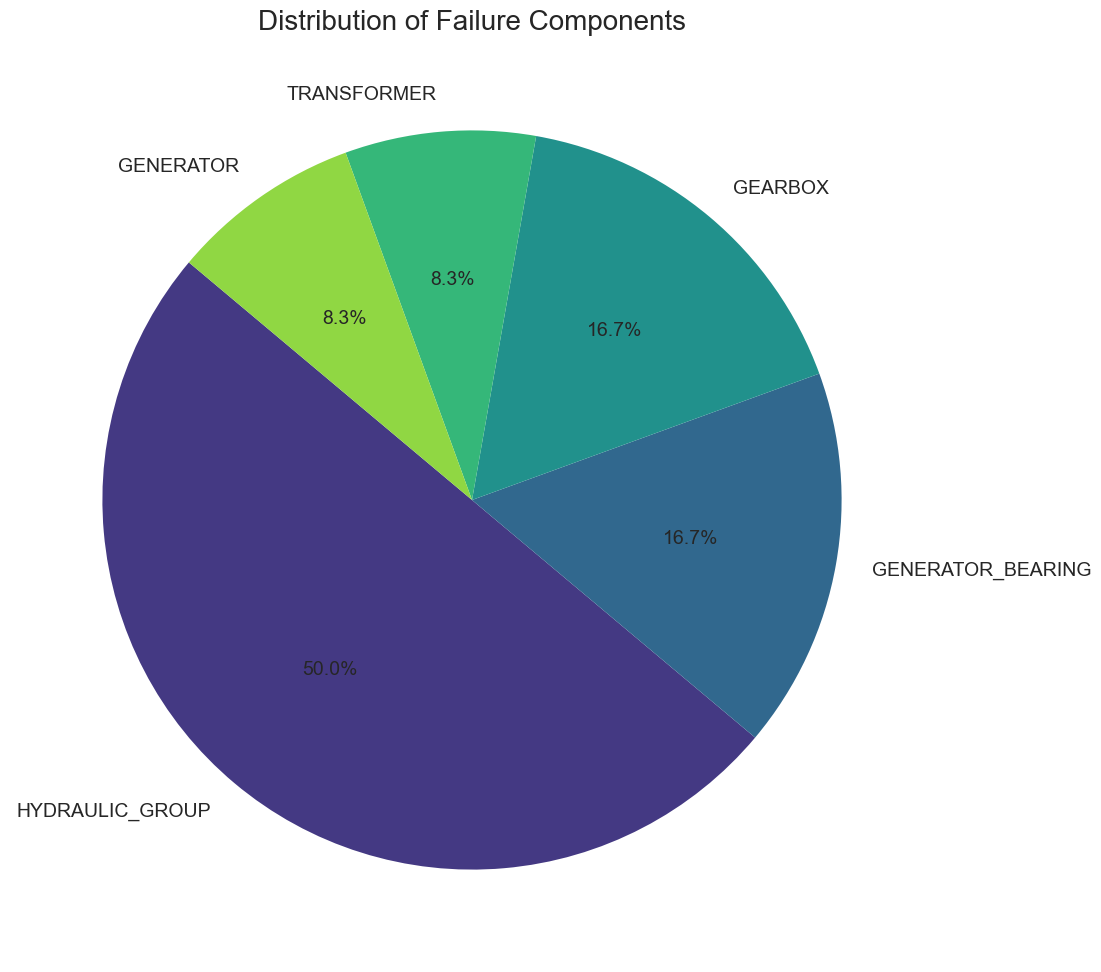

In [3]:
fail_counts = failure['Component'].value_counts()

plt.figure(figsize=(12, 12))
plt.pie(
    fail_counts,
    labels=fail_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("viridis", len(fail_counts)),
    textprops={'fontsize': 14}
)
plt.title('Distribution of Failure Components', fontsize=20)
plt.show()

## 3. Power Curve Analysis

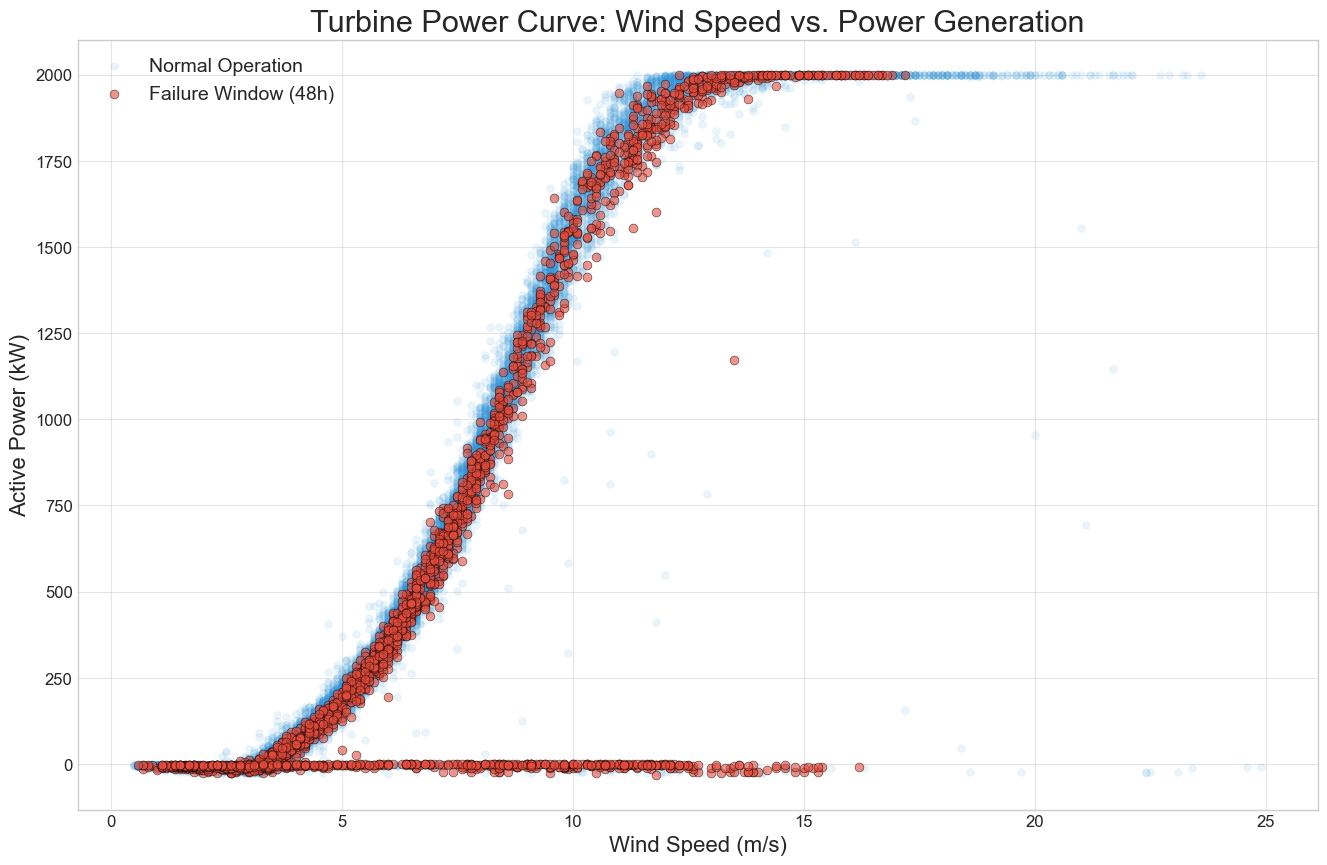

In [4]:
plt.figure(figsize=(16, 10))

df_sample = df.sample(frac=0.1, random_state=42)

sns.scatterplot(
    data=df_sample[df_sample['Label'] == 0], 
    x='Amb_WindSpeed_Avg', 
    y='Grd_Prod_Pwr_Avg', 
    alpha=0.1, 
    color='#3498db', 
    label='Normal Operation',
    s=30,
    edgecolor=None
)

sns.scatterplot(
    data=df[df['Label'] == 1], 
    x='Amb_WindSpeed_Avg', 
    y='Grd_Prod_Pwr_Avg', 
    alpha=0.6, 
    color='#e74c3c', 
    label='Failure Window (48h)',
    s=40,
    edgecolor='black',
    linewidth=0.5
)

plt.title('Turbine Power Curve: Wind Speed vs. Power Generation', fontsize=22)
plt.xlabel('Wind Speed (m/s)', fontsize=16)
plt.ylabel('Active Power (kW)', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.grid(True, alpha=0.5)
plt.show()

## 4. Feature Distributions (KDE Plots)

IndexError: index 6 is out of bounds for axis 0 with size 6

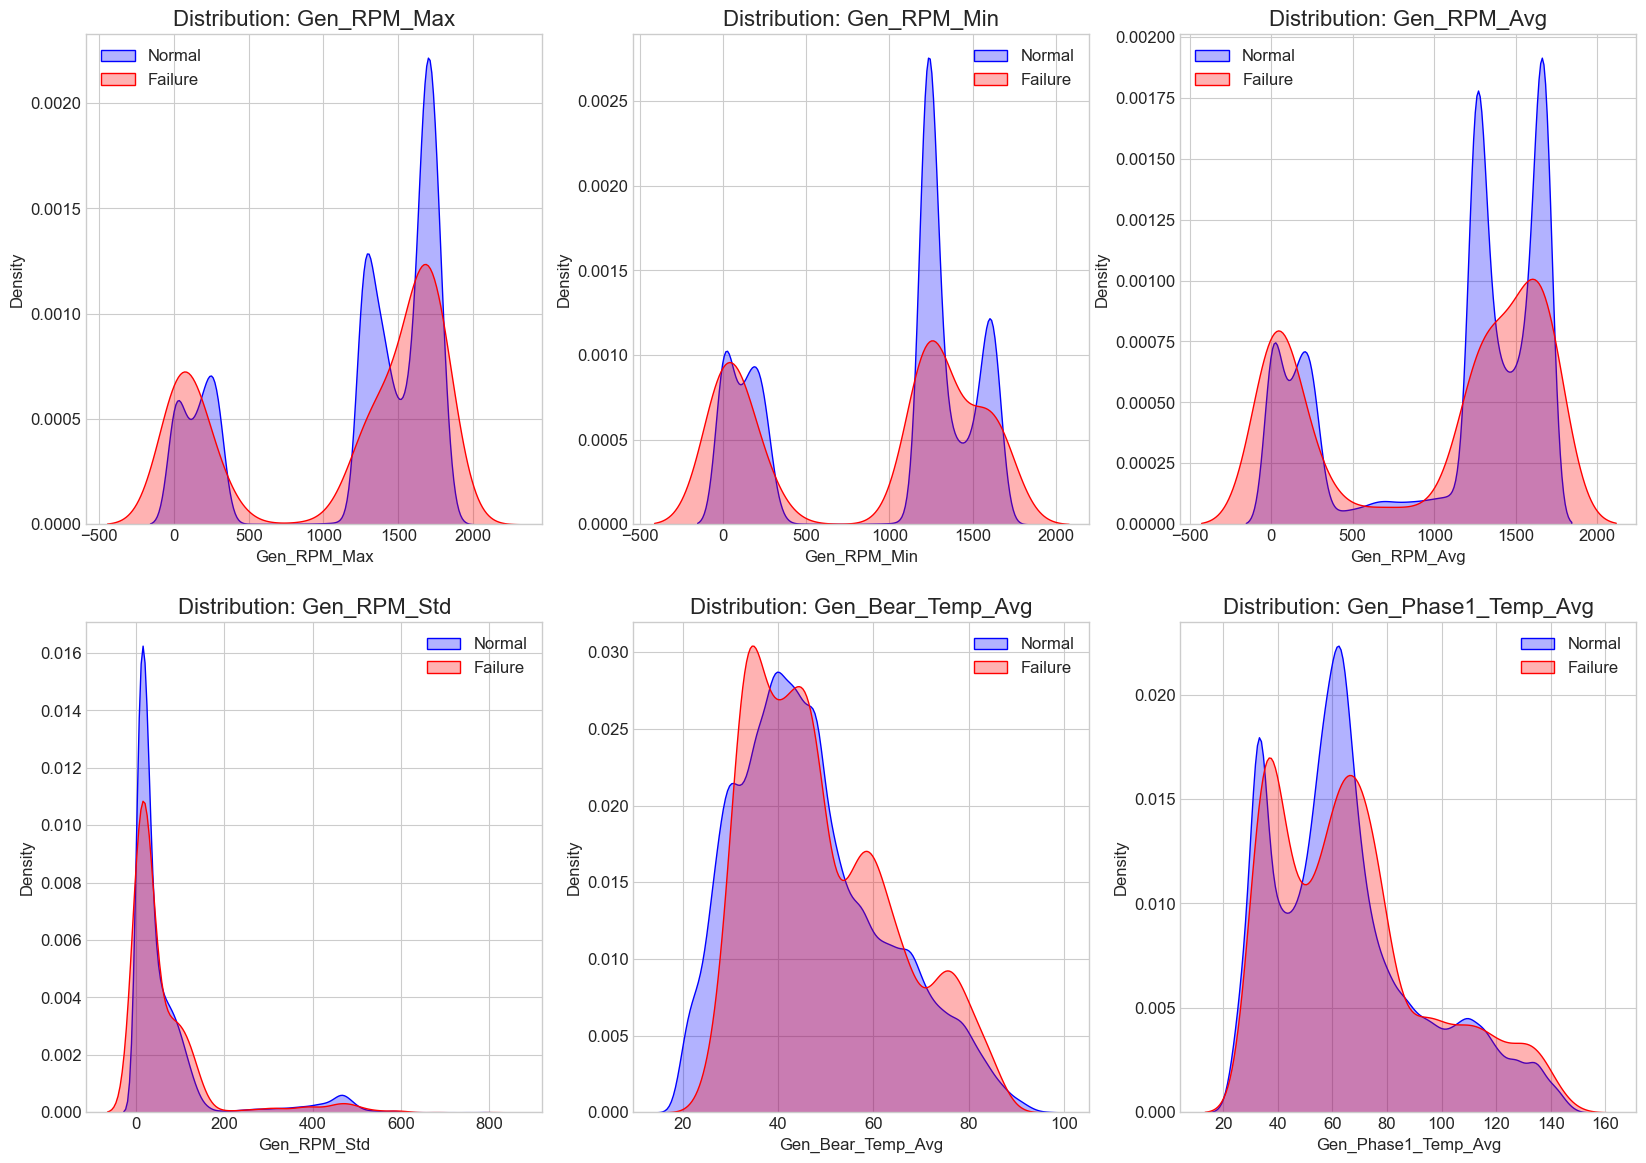

In [ ]:
import math

# 1. Definir features
cols_to_exclude = ['Timestamp', 'Label', 'Turbine_ID', 'Component']
features_to_plot = [col for col in scada.columns if col not in cols_to_exclude]
n_features = len(features_to_plot)

# 2. Calcular layout dinâmico
n_cols = 3  # Número de colunas que você quer
n_rows = math.ceil(n_features / n_cols)  # Calcula linhas necessárias

# 3. Criar figura com tamanho ajustado
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows)) # Altura cresce com as linhas
axes = axes.flatten() # Transforma em vetor para facilitar iteração

# 4. Plotar
for i, col in enumerate(features_to_plot):
    if col in df.columns:
        # Plot Normal
        sns.kdeplot(data=df[df['Label']==0], x=col, label='Normal', fill=True, alpha=0.3, color='blue', ax=axes[i])
        # Plot Failure
        sns.kdeplot(data=df[df['Label']==1], x=col, label='Failure', fill=True, alpha=0.3, color='red', ax=axes[i])
        
        axes[i].set_title(f'Distribution: {col}', fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Density', fontsize=10)
        axes[i].legend()

# 5. Remover eixos vazios (se sobrarem espaços no grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 5. Seasonal Temporal Analysis (-7 Days Comparison)

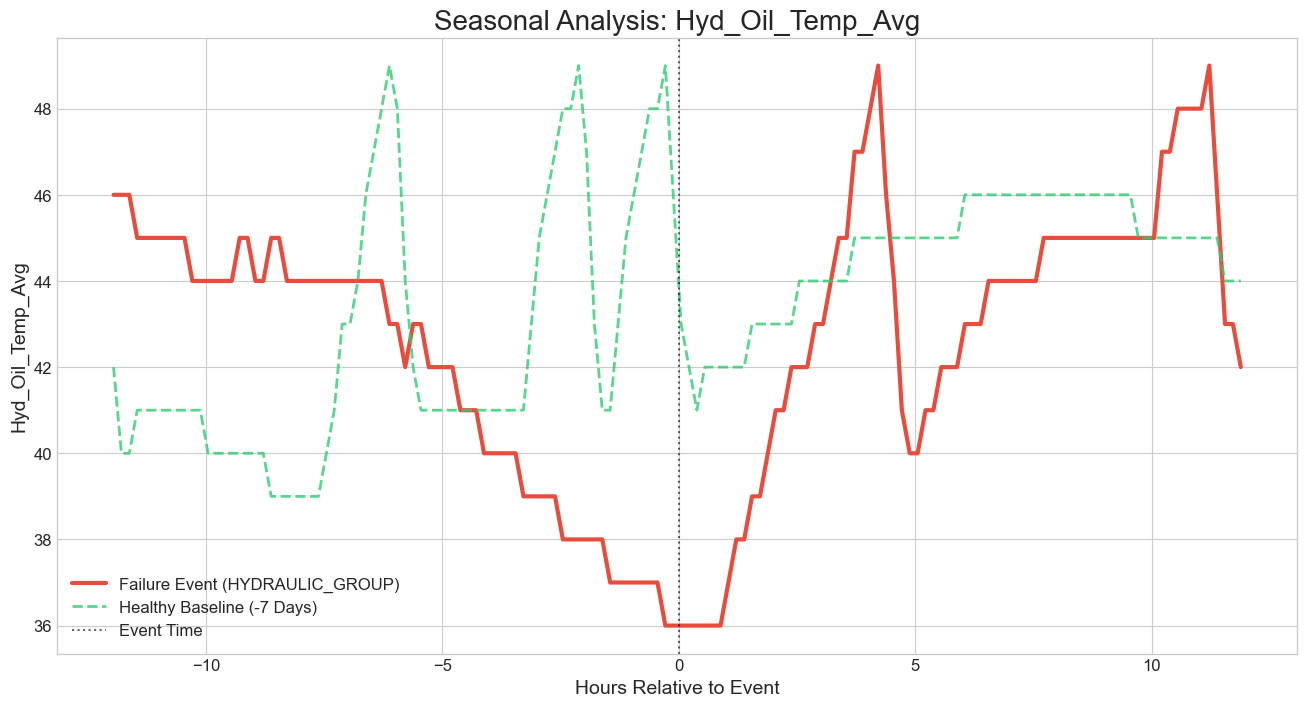

In [6]:
def plot_seasonal_context(feature_name, failure_idx=0):
    if failure_idx >= len(failure):
        return
        
    fail_event = failure.iloc[failure_idx]
    t_id = fail_event['Turbine_ID']
    t_fail = fail_event['Timestamp']
    component = fail_event['Component']
    
    window = pd.Timedelta(hours=12)
    
    mask_fail = (df['Turbine_ID'] == t_id) & (df['Timestamp'] >= t_fail - window) & (df['Timestamp'] <= t_fail + window)
    df_fail = df[mask_fail].copy()
    if not df_fail.empty:
        df_fail['Rel_Time'] = (df_fail['Timestamp'] - t_fail).dt.total_seconds() / 3600

    t_healthy = t_fail - pd.Timedelta(days=7)
    
    mask_healthy = (
        (df['Turbine_ID'] == t_id) & 
        (df['Label'] == 0) & 
        (df['Timestamp'] >= t_healthy - window) & 
        (df['Timestamp'] <= t_healthy + window)
    )
    df_healthy = df[mask_healthy].copy()
    
    if df_healthy.empty:
        t_healthy = t_fail - pd.Timedelta(days=14)
        mask_healthy = ((df['Turbine_ID'] == t_id) & (df['Label'] == 0) & (df['Timestamp'] >= t_healthy - window) & (df['Timestamp'] <= t_healthy + window))
        df_healthy = df[mask_healthy].copy()

    if not df_healthy.empty:
        df_healthy['Rel_Time'] = (df_healthy['Timestamp'] - t_healthy).dt.total_seconds() / 3600

    plt.figure(figsize=(16, 8))
    
    if not df_fail.empty:
        sns.lineplot(data=df_fail, x='Rel_Time', y=feature_name, label=f'Failure Event ({component})', color='#e74c3c', linewidth=3)
        
    if not df_healthy.empty:
        sns.lineplot(data=df_healthy, x='Rel_Time', y=feature_name, label='Healthy Baseline (-7 Days)', color='#2ecc71', linestyle='--', alpha=0.8, linewidth=2)
    
    plt.axvline(0, color='black', linestyle=':', alpha=0.6, label='Event Time')
    plt.title(f'Seasonal Analysis: {feature_name}', fontsize=20)
    plt.xlabel('Hours Relative to Event', fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

hyd_fails = failure[failure['Component'].str.contains("HYDRAULIC", case=False)]
if not hyd_fails.empty:
    plot_seasonal_context('Hyd_Oil_Temp_Avg', failure_idx=hyd_fails.index[0])

## 6. Post-Failure Recovery Analysis

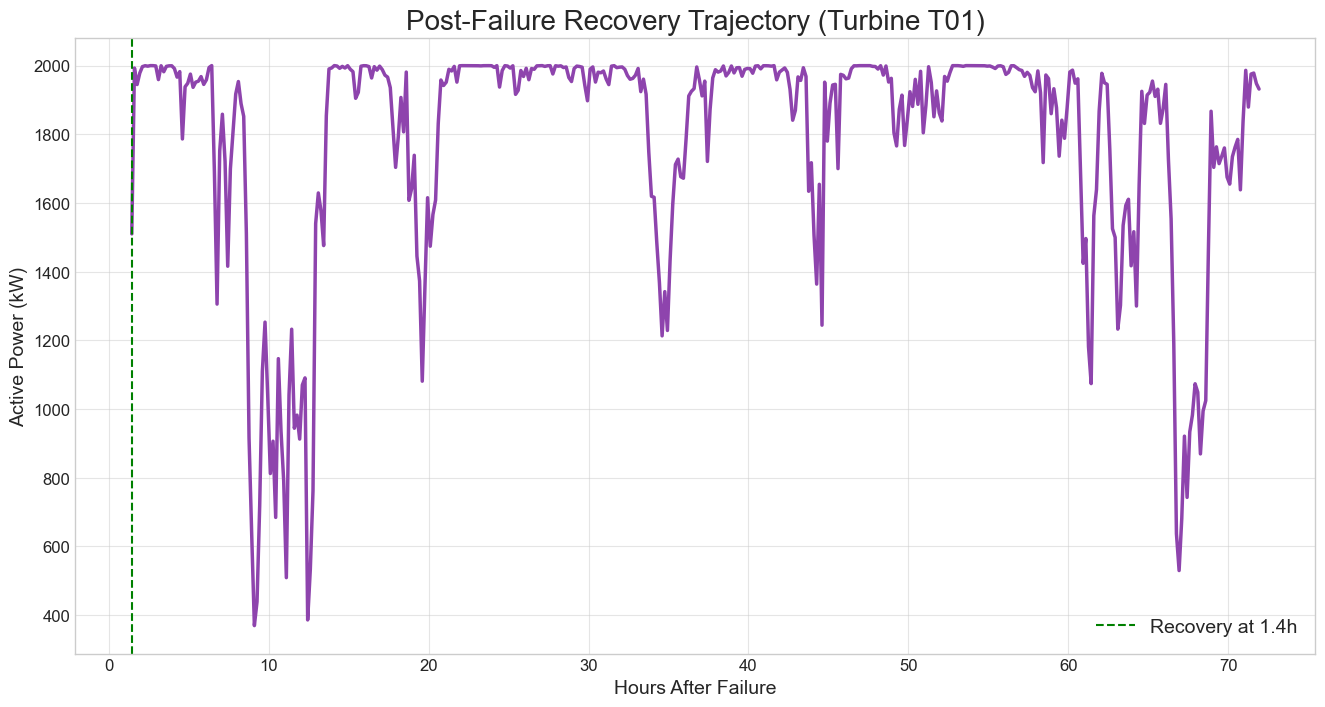

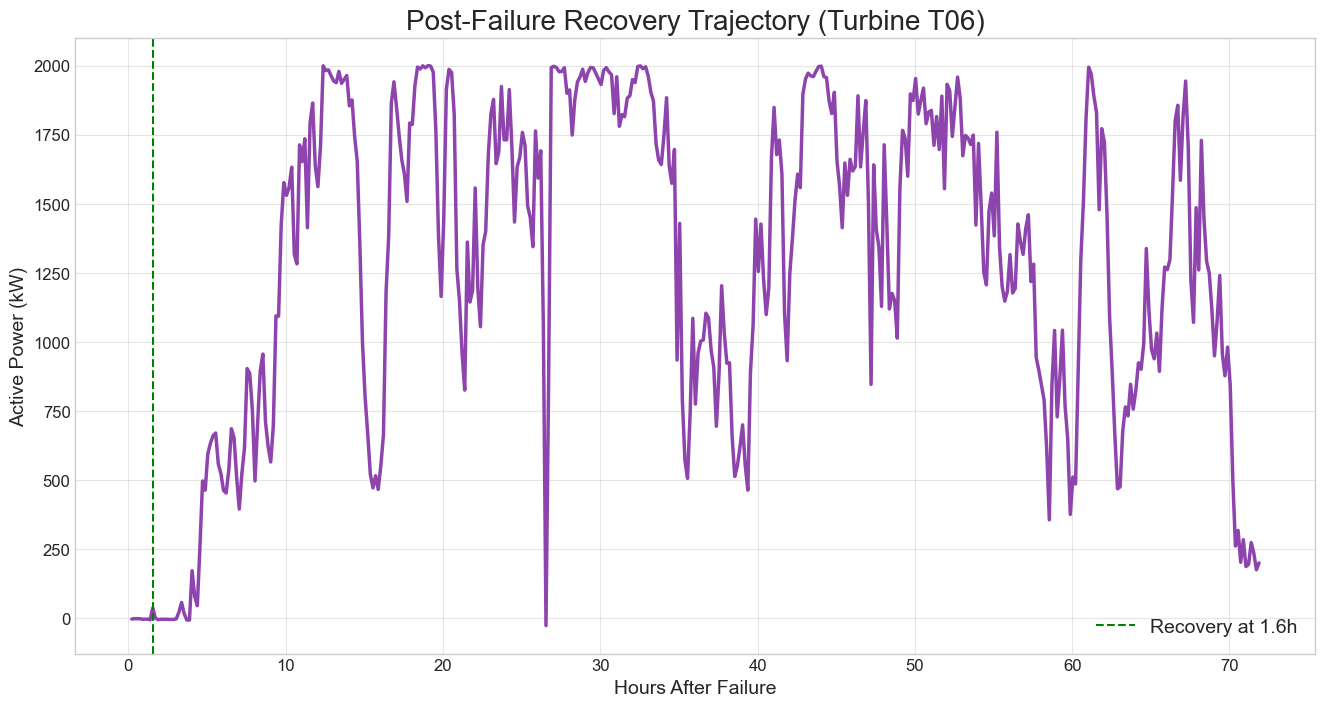

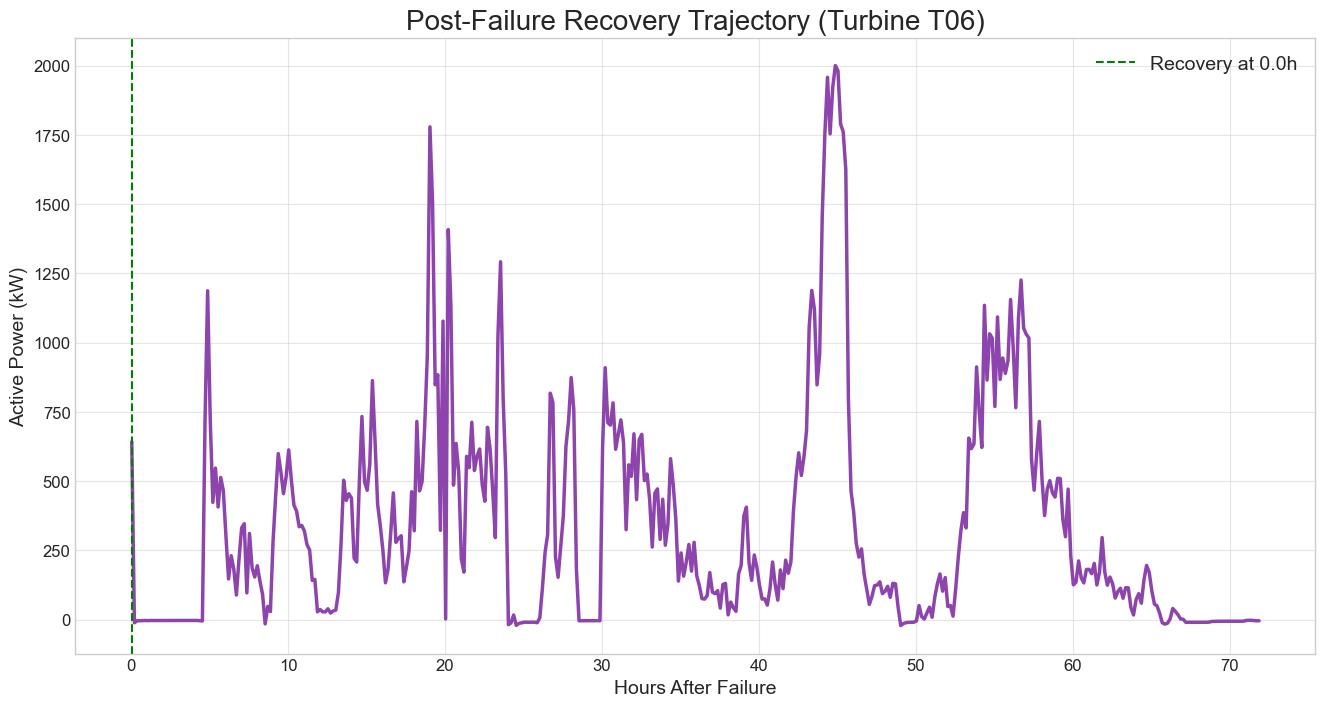

In [7]:
def analyze_recovery(failure_idx=0):
    fail_event = failure.iloc[failure_idx]
    t_id = fail_event['Turbine_ID']
    t_fail = fail_event['Timestamp']
    
    # Window: 0 to +72h
    window_end = t_fail + pd.Timedelta(hours=72)
    
    mask = (df['Turbine_ID'] == t_id) & (df['Timestamp'] >= t_fail) & (df['Timestamp'] <= window_end)
    df_rec = df[mask].copy()
    
    if df_rec.empty:
        return
        
    df_rec['Hours_After'] = (df_rec['Timestamp'] - t_fail).dt.total_seconds() / 3600
    
    # Calculate Downtime (Time until Power > 10kW)
    recovery_point = df_rec[df_rec['Grd_Prod_Pwr_Avg'] > 10].head(1)
    downtime = 72.0
    if not recovery_point.empty:
        downtime = recovery_point['Hours_After'].values[0]
    
    plt.figure(figsize=(16, 8))
    sns.lineplot(data=df_rec, x='Hours_After', y='Grd_Prod_Pwr_Avg', color='#8e44ad', linewidth=2.5)
    
    if downtime < 72:
        plt.axvline(downtime, color='green', linestyle='--', label=f'Recovery at {downtime:.1f}h')
        
    plt.title(f'Post-Failure Recovery Trajectory (Turbine {t_id})', fontsize=20)
    plt.xlabel('Hours After Failure', fontsize=14)
    plt.ylabel('Active Power (kW)', fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.5)
    plt.show()

# Analyze first 3 failures
for i in range(3):
    analyze_recovery(i)